# Evaluator Notebook

Generate outputs from the LLM annotation, and then score that and human annotation

## LLM Annotation

In [1]:
import json
import pandas as pd
import numpy as np
from copy import deepcopy
from tqdm import tqdm
from sync_utils import get_predictions_for_version
from llmclient import LLMClient

#MODEL = "dev-gpt-o3-mini"
MODEL = "dev-phi-35-moe-instruct"
#MODEL = "dev-gpt-4o-2024-05-13-chat-completions"
tokens = 1024 #3
#MODEL = "dev-mixtral-8x7b-instruct-v01"
#MODEL = "dev-deepseek-r1-distill-qwen-32b"
#tokens = 50000 #deepseek, else 512
model_key = MODEL.replace("dev-", "")

tkey = "max_tokens" if "o3" not in MODEL else "max_completion_tokens"
max_apo_tokens = 1024
params = {tkey: tokens,} 
if "o3" not in MODEL:
    params["temperature"] = 0
llm = LLMClient(params, MODEL)

### LLM Call

In [2]:
dataset = pd.read_json("processed_transcripts/final_dataset.json")

In [3]:
new_dataset = []
for k in tqdm(range(len(dataset))):
    subset = dataset.loc[k]
    new_subset = deepcopy(subset)
    new_subset["Annotations"][model_key] = {"Winner": None, 
                                            "TranscriptScores": []}
    for version in "01234567":
        responses = get_predictions_for_version(subset, version, MODEL, llm, prompt_override=None)
        if version == "7":
            new_subset["Annotations"][model_key]["Winner"] = responses["Winner"]
            new_subset["Annotations"][model_key]["Winner_reason"] = responses["Winner_reason"]
        else:
            for i, r in enumerate(responses):
                if version == "0":
                    new_subset["Annotations"][model_key]["TranscriptScores"].append(r)
                else:
                    for q in ["P1", "P2"]:
                        new_subset["Annotations"][model_key]["TranscriptScores"][i][f"{q}Scores"][f"C-{version}"] = r[f"{q}Scores"][f"C-{version}"]
                        new_subset["Annotations"][model_key]["TranscriptScores"][i][f"{q}Scores"][f"C-{version}_reason"] = r[f"{q}Scores"][f"C-{version}_reason"]

    new_subset.to_json(f"tmp_debaters_with_phi3_{k}.json", force_ascii=False)
    new_dataset.append(new_subset)

100%|██████████| 51/51 [6:32:46<00:00, 462.09s/it]   


Dump the data

In [4]:
import glob
subsets = []
for f in glob.glob("tmp_debaters_with_phi3_*.json"):
    subsets.append(json.load(open(f, "r", encoding="utf-8")))
df = pd.DataFrame(subsets)

df.to_json("processed_transcripts/final_dataset_with_phi3.json")

### APO

In [ ]:
from copy import deepcopy
from tqdm import tqdm
from llmclient import LLMClient
from prompts import (get_annotator_prompt_c012,
                     get_annotator_prompt_c3456, 
                     get_annotator_prompt_c7)
from apo_utils import construct_full_subset, apo
import json

MODEL = "dev-gpt-o3-mini" # I recommend using GPT-4o
tokens = 75000 # for o3
model_key = MODEL

tkey = "max_tokens" if "o3" not in MODEL else "max_completion_tokens"
max_apo_tokens = 1024
tokens = 512
params = {tkey: tokens,} 
if "o3" not in MODEL:
    params["temperature"] = 0
llm = LLMClient(params, MODEL)

dataset = json.load(open("processed_transcripts/final_dataset.json", "r", encoding="utf-8"))

In [ ]:
# Run APO for each version separately
subset = construct_full_subset(dataset[0]) + construct_full_subset(dataset[12])
subset += construct_full_subset(dataset[48])

for version in tqdm("234567"):

    if version in "012":
        prompt = get_annotator_prompt_c012("", version, False, developer=False)[0]["content"]
    if version in "3456":
        prompt = get_annotator_prompt_c3456("", version, False, developer=False)[0]["content"]
    if version in "7":
        prompt = get_annotator_prompt_c7("", version, False, developer=False)[0]["content"]

    p_hat_candidates = apo(prompt, subset, version, llm, beam_width=4, search_depth=6, 
                           max_token_override={"tkey": tkey, "tokens": max_apo_tokens}) # Use training for optimisation
    p_hat = p_hat_candidates[0][0]
    score = p_hat_candidates[0][-1]

    with open(f"processed_transcripts/apo_prompt_{version}.json", "w", encoding="utf-8") as f:
        f.write(json.dumps({"Prompt": p_hat, "Score": score, 
                            "InitialPrompt": prompt, "OtherCandidates": p_hat_candidates, 
                            "Version": version}, ensure_ascii=False))
    with open(f"processed_transcripts/apo_prompts_.json", "a", encoding="utf-8") as f:
        f.write(json.dumps({"Prompt": p_hat[0], "Version": version, "OtherCandidates": p_hat_candidates,},
                           ensure_ascii=False) + ",\n")


In [ ]:
from apo_utils import get_predictions_for_version_collection_apo

MODEL = "gpt-4o-2024-05-13"
tkey = "max_tokens" if "o3" not in MODEL else "max_completion_tokens"
tokens = 1024
params = {tkey: tokens,} 
if "o3" not in MODEL: params["temperature"] = 0
llm = LLMClient(params, MODEL)

prompts = []
for version in "01234567":
    line = [json.loads(l) for l in open(f"processed_transcripts/apo_prompt_{version}.json", "r", encoding="utf-8").readlines()]
    prompts.append(line[0])

In [ ]:
new_dataset = []
for i in tqdm(range(len(dataset))):
    subset = dataset[i]
    new_subset = deepcopy(subset)
    new_subset["Annotations"]["gpt4o_from_apo"] = {"Winner": None, 
                                                   "TranscriptScores": []}
    for version in "01234567":
        prompt = [p["Prompt"] for p in prompts if p["Version"] == version][0]
        responses = get_predictions_for_version_collection_apo(subset, version, llm, prompt_override=prompt)
        if version == "7":
            new_subset["Annotations"]["gpt4o_from_apo"]["Winner"] = responses["Winner"]
            new_subset["Annotations"]["gpt4o_from_apo"]["Winner_reason"] = responses["Winner_reason"]
        else:
            for i, r in enumerate(responses):
                if version == "0":
                    new_subset["Annotations"]["gpt4o_from_apo"]["TranscriptScores"].append(r)
                else:
                    for q in ["P1", "P2"]:
                        new_subset["Annotations"]["gpt4o_from_apo"]["TranscriptScores"][i][f"{q}Scores"][f"C-{version}"] = r[f"{q}Scores"][f"C-{version}"]
                        new_subset["Annotations"]["gpt4o_from_apo"]["TranscriptScores"][i][f"{q}Scores"][f"C-{version}_reason"] = r[f"{q}Scores"][f"C-{version}_reason"]

    new_dataset.append(new_subset)

In [ ]:
with open("processed_transcripts/final_dataset_scored_corrected_apo.json", "w", encoding="utf-8") as f:
    json.dump(new_dataset, f, ensure_ascii=False)

# Data Processing

### Shared Structures

Run this before the other bits

In [ ]:
from sklearn.metrics import cohen_kappa_score
import numpy as np
from collections import Counter
import pandas as pd

dataset = pd.read_json(open("processed_transcripts/final_dataset.json", "r", encoding="utf-8"))

MODELS = ['gpt-4o-2024-05-13', 'gpt4o_from_apo', 
          #'mixtral-8x7b-instruct-v01',  # Mixtral was so bad we dropped it
          'deepseek-r1-distill-qwen-32b', 
          "phi-35-moe-instruct",
          'o3-mini']


labels_from = {
    "C-0": [2, 1, 0, -1],
    "C-1": [2, 1, 0, -1],
    "C-2": [2, 1, 0, -1],
    "C-3": [2, 1, 0, -1],
    "C-4": [2, 1, 0, -1],
    "C-5": [2, 1, 0, -1],
    "C-6": [2, 1, 0, -1, -2, -3],
    "Winner": ["p1", "p2", "draw"]
}

intervals = {"ChatGPT": (0, 9), "LLM + FDM": (9, 19), "LLM + LLM": (19, 51)}

def normalise(arr, criterion):
    if criterion not in ["C-6", "Winner"]:
        new_arr = [x if not pd.isnull(x) else -1 for x in arr]
    elif criterion == "C-6":
        new_arr = [x if not pd.isnull(x) else -3 for x in arr]
    else:
        new_arr = []
        for x in arr:
            if type(x) == str:
                new_arr.append(x.capitalize())
            else:
                new_arr.append("Draw")
    return new_arr


# a = human / b = GPT-4o
def get_acc(a, b):
    if a is None:
        a = np.nan
    if b is None:
        b = np.nan
    try:
        if type(a) != str and type(b) != str:
            if pd.isnull(a) and pd.isnull(b):
                return True
    except:
        print(a, b)
        raise
    return a == b


def compute_weighted_kappa(column1, column2, labels, criterion):
    """
    Compute the weighted Cohen's kappa for two arrays corresponding
    to a given metric
    """
    def remap(x):
        if type(x) == str:
            if x == '': x = "FAIL"
            return labels_from["Winner"].index(x.lower()) if x != "FAIL" else labels_from["Winner"].index("draw")
        else:
            return 2 # Draw
    
    def safe_remap(x):
        if x is None:
            return np.nan
        if type(x) == str:
            return int(x)
        return x

    if criterion == "Winner":
        labels = [0, 1, 2, -1]
        column1 = [remap(a) for a in column1]
        column2 = [remap(b) for b in column2]
    else:
        column1 = normalise([safe_remap(a) for a in column1], criterion)
        column2 = normalise([safe_remap(a) for a in column2], criterion)

        #kappa = round(cohen_kappa_score([a if not np.isnan(a) else w for a in column1], 
        #                                [a if not np.isnan(a) else w for a in column2], weights="linear", labels=labels), 3)

    kappa = round(cohen_kappa_score(column1, column2, weights="linear", labels=labels), 3)
    return kappa, column1, column2


def normalised_score(entry, aggr):
    missing_playas = []
    if entry is None:
        entry = {}
    for p in ["P1Scores", "P2Scores"]:
        if p not in entry or entry[p] == {}:
            missing_playas.append(p)
    for p in missing_playas:
        entry[p] = {k: np.nan for k in aggr.keys() if k.startswith("C")}
    return entry


def get_majority_vote(scores):
    """
    Get majority vote for an array
    """
    _z = Counter(scores)
    z = _z.most_common()

    if len(z) > 1:
        if z[0][-1] == z[1][-1]:
            return int((z[0][0] + z[1][0])/2)
    return z[0][0]


In [26]:
agreements = {k: [[], [], [], [], []] for k in ['C-0', 'C-1', 'C-2', 'C-3', 'C-4',
                                                 'C-5', 'C-6', 'Winner']}
humans = ['A0', 'A1', 'A2', 'A3', 'A4']
human_kappa = {}
human_kappa_by_transcript = {
    "ChatGPT": {},
    "LLM + FDM": {},
    "LLM + LLM": {}}

ranges = {"ChatGPT": 0, "LLM + FDM": 0, "LLM + LLM": 0}

for ix in dataset.index:
    k = "Winner"
    tid = dataset.loc[ix]["TranscriptId"]

    key = "LLM + FDM"
    if tid.startswith("D"): key = "ChatGPT"
    if "False" in tid: key = "LLM + LLM"
    if ranges[key] == 0:
        ranges[key] = ix

    max_turns = max([max([t["Turn"] for t in s]) for s in [
        dataset.loc[ix]["Annotations"][hh]["TranscriptScores"] for hh in humans
    ]])
    for jx, h in enumerate(humans):
        agreements[k][jx].append(
            dataset.loc[ix]["Annotations"][h][k]
        )

    aggregates = [dataset.loc[ix]["Annotations"][h]["TranscriptScores"] for h in humans]
    max_turns = max([max([t["Turn"] for t in s]) for s in aggregates])
    # This way we evaluate ALL the turns
    for t in range(1, max_turns + 1):
        axx = []
        for ix, h in enumerate(humans):
            ax = [normalised_score(p, agreements) for p in aggregates[ix] if p["Turn"] == t]
            if ax == []: ax = [normalised_score(None, agreements)]
            axx.append(ax[0])
        for playa in ["P1", "P2"]:
            for k in agreements.keys():
                for jx, h in enumerate(humans):
                    if k != "Winner":
                        agreements[k][jx].append(axx[jx][f"{playa}Scores"][k])


print(f"----Human------")
avgs = 0

for zx, (k, v) in enumerate(agreements.items()):

    tmp_kappas = {k: [] for k in human_kappa_by_transcript.keys()}
    pairwise_cohen = []
    for ix in range(len(humans) - 1):
        for jx in range(ix + 1, len(humans)):
            kappa, c1, c2 = compute_weighted_kappa(v[ix], v[jx], labels_from[k], k)
            pairwise_cohen.append(kappa)

            for key in human_kappa_by_transcript.keys():
                a, b = intervals[key]
                _kappa, _, _ = compute_weighted_kappa(v[ix][a:b], v[jx][a:b], labels_from[k], k)
                tmp_kappas[key].append(_kappa)

    print(k, np.average(pairwise_cohen))
    human_kappa[k] = np.average(pairwise_cohen)

    for key in human_kappa_by_transcript.keys():
        human_kappa_by_transcript[key][k] = np.average(tmp_kappas[key])

    avgs += human_kappa[k] if k != "Winner" else 0

print(avgs/7)

----Human------
C-0 0.8765000000000001
C-1 0.8462999999999999
C-2 0.8368
C-3 0.8291000000000001
C-4 0.7324
C-5 0.8024000000000001
C-6 0.7685
Winner 0.4272
0.8131428571428572


In [43]:
agreements = {'C-0': [[], []], 'C-1': [[], []], 'C-2': [[], []], 'C-3': [[], []],
            'C-4': [[], []], 'C-5': [[], []], 'C-6': [[], []], 'Winner': [[], []]}
kappas = {m: {k: [] for k in agreements.keys()} for m in MODELS}
classes = {m: {k: [] for k in agreements.keys()} for m in MODELS}
acc_classes = {m: {k: [] for k in agreements.keys()} for m in MODELS}
kappas_by_transcript = {n: {
    m: {k: [] for k in agreements.keys()} for m in MODELS
    } for n in ["ChatGPT", "LLM + FDM", "LLM + LLM"]
    }

total_avgs = {c: 0 for c in agreements.keys()}

for model in MODELS:
    agreements = {'C-0': [[], []], 'C-1': [[], []], 'C-2': [[], []], 'C-3': [[], []],
                'C-4': [[], []], 'C-5': [[], []], 'C-6': [[], []], 'Winner': [[], []]}
    for ix in dataset.index:
        # We do winner separately because it SHOULD be out of the transcript scores
        k = "Winner"
        agreements[k][0].append(dataset.loc[ix]["Annotations"]["AggregateHuman"][k])
        agreements[k][-1].append(dataset.loc[ix]["Annotations"][model][k])

        aggregates = dataset.loc[ix]["Annotations"]["AggregateHuman"]["TranscriptScores"]
        gpt4o = dataset.loc[ix]["Annotations"][model]["TranscriptScores"]
        max_turns = max([max([t["Turn"] for t in s]) for s in [gpt4o, aggregates]])
        # This way we evaluate ALL the turns
        for t in range(1, max_turns + 1):
            ax = [normalised_score(p, agreements) for p in aggregates if p["Turn"] == t]
            gx = [normalised_score(p, agreements) for p in gpt4o if p["Turn"] == t]
            if ax == []: ax = [normalised_score(None, agreements)]
            if gx == []: gx = [normalised_score(None, agreements)]
            ax, gx = ax[0], gx[0]
            for playa in ["P1", "P2"]:
                for k in agreements.keys():
                    if k != "Winner":
                        agreements[k][0].append(ax[f"{playa}Scores"][k])
                        agreements[k][-1].append(gx[f"{playa}Scores"][k])

    print(f"===={model}====")
    accs = []
    kapps = []
    for zx, (k, v) in enumerate(agreements.items()):
        tmp_kappas = {e: 0 for e in kappas_by_transcript.keys()}
        accuracy = round(sum([get_acc(a,  b) for a, b in zip(*v)])*100./len(v[0]), 2)
        kappa, c1, c2 = compute_weighted_kappa(v[0], v[1], labels_from[k], k)
        for key in tmp_kappas.keys():
            a, b = intervals[key]
            _kappa, _, _ = compute_weighted_kappa(v[0][a:b], v[1][a:b], labels_from[k], k)
            #print(v[0][a:b][0], v[1][a:b][0], _kappa)
            tmp_kappas[key] = _kappa

        kappas[model][k] = kappa
        acc_classes[model][k] = accuracy
        classes[model][k] = [(a,b) for a, b in zip(c1, c2)]

        for key in tmp_kappas.keys():
            kappas_by_transcript[key][model][k] = tmp_kappas[key]

        print(k, accuracy, kappa)
        if "C" in k:
            accs.append(accuracy), kapps.append(kappa)
            total_avgs[k] += kappa
    print("-------")
    print(f"C-* {round(sum(accs)/len(accs), 2)} {round(sum(kapps)/len(kapps), 2)} | max: {max(accs), max(kapps)} | min: {min(accs), min(kapps)}")

print({k: round(v/len(MODELS), 2) for k, v in total_avgs.items()})

====gpt-4o-2024-05-13====
C-0 45.69 0.296
C-1 81.21 0.614
C-2 72.21 0.612
C-3 34.25 0.335
C-4 52.15 0.485
C-5 77.01 0.321
C-6 43.93 0.481
Winner 66.67 0.49
-------
C-* 58.06 0.45 | max: (81.21, 0.614) | min: (34.25, 0.296)
====gpt4o_from_apo====
C-0 52.74 0.298
C-1 70.35 0.197
C-2 67.22 0.37
C-3 45.79 0.287
C-4 43.25 0.343
C-5 78.67 0.344
C-6 15.66 0.035
Winner 25.49 0.355
-------
C-* 53.38 0.27 | max: (78.67, 0.37) | min: (15.66, 0.035)
====deepseek-r1-distill-qwen-32b====
C-0 41.19 0.165
C-1 44.23 0.126
C-2 41.68 0.112
C-3 32.58 0.058
C-4 28.67 0.123
C-5 23.78 0.018
C-6 18.79 0.032
Winner 27.45 0.411
-------
C-* 32.99 0.09 | max: (44.23, 0.165) | min: (18.79, 0.018)
====phi-35-moe-instruct====
C-0 42.07 0.171
C-1 41.1 0.01
C-2 43.84 0.062
C-3 23.29 -0.001
C-4 28.38 0.126
C-5 35.23 0.028
C-6 20.74 0.109
Winner 25.49 0.261
-------
C-* 33.52 0.07 | max: (43.84, 0.171) | min: (20.74, -0.001)
====o3-mini====
C-0 22.11 0.05
C-1 63.11 0.229
C-2 57.53 0.211
C-3 32.78 0.125
C-4 28.96 0.162
C-

### Plots (scoring)

In [28]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme()

maptocol = {
    "gpt-4o-2024-05-13": "GPT-4o",
    "gpt4o_from_apo": "GPT-4o (APO)",
    #"mixtral-8x7b-instruct-v01": "Mixtral 8x7B",
    "o3-mini": "o3-mini", "phi-35-moe-instruct": "phi-35",
    "deepseek-r1-distill-qwen-32b": "Deepseek R1",
    "Human": "Human"
}


In [29]:

index = ["C-0", "C-1", "C-2", "C-3", "C-4", "C-5", "C-6", "Winner"]
all_agreements = {k: [_v for _, _v in v.items()] for k, v in kappas.items()}
all_agreements["Human"] = [v for k, v in human_kappa.items()]
all_agreements = pd.DataFrame(all_agreements, index=index)

categories = all_agreements.index.tolist()
categories.append(categories[0]) 

fig = go.Figure()

fig.update_layout(autosize=False, width=500, height=500, margin=dict(l=50, r=50, b=50, t=50, pad=1))

for col in all_agreements.columns:
    col_name = maptocol[col]
    values = all_agreements[col].tolist()
    values.append(values[0])
    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories,
        name=col_name,
        opacity=0.75
    ))

# set the legend at the bottom with 4 columns
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", xanchor="center", x=0.5, y=-0.15)) #, y=0.5,))
fig.update_layout(
    title=dict(
        font_family="Times New Roman",
        text="Cohen's κ for Annotators",
        font=dict(size=24),
        y=0.99, yanchor='top'
        ),
    legend=dict(y=-0.25)
)

fig.update_layout(
  polar=dict(
    radialaxis=dict(visible=True, range=[0,1.0])
    ), showlegend=True
)

fig.show()

In [30]:

index = ["C-0", "C-1", "C-2", "C-3", "C-4", "C-5", "C-6", "Winner"]
all_agreements = {k: [_v for _, _v in v.items()] for k, v in acc_classes.items()}
#all_agreements["Human"] = [v for k, v in human_kappa.items()]
all_agreements = pd.DataFrame(all_agreements, index=index)

categories = all_agreements.index.tolist()
categories.append(categories[0]) 

fig = go.Figure()

fig.update_layout(autosize=False, width=500, height=500, margin=dict(l=50, r=50, b=50, t=50, pad=1))

for col in all_agreements.columns:
    col_name = maptocol[col]
    values = all_agreements[col].tolist()
    values.append(values[0])
    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories,
        name=col_name,
        opacity=0.75
    ))

# set the legend at the bottom with 4 columns
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", xanchor="center", x=0.5, y=-0.15)) #, y=0.5,))
fig.update_layout(
    title=dict(
        font_family="Times New Roman",
        text="PA for Annotators",
        font=dict(size=24),
        y=0.99, yanchor='top'
        ),
    legend=dict(y=-0.25)
)

fig.update_layout(
  polar=dict(
    radialaxis=dict(visible=True, range=[0,100])
    ), showlegend=True
)

fig.show()

In [31]:
for key in kappas_by_transcript.keys():

    index = ["C-0", "C-1", "C-2", "C-3", "C-4", "C-5", "C-6", "Winner"]
    all_agreements = {k: [_v for _, _v in v.items()] for k, v in kappas_by_transcript[key].items()}
    all_agreements["Human"] = [v for k, v in human_kappa_by_transcript[key].items()]
    all_agreements = pd.DataFrame(all_agreements, index=index)

    categories = all_agreements.index.tolist()
    categories.append(categories[0]) 

    fig = go.Figure()
    fig.update_layout(autosize=False, width=500, height=500, margin=dict(l=50, r=50, b=50, t=50, pad=1))

    for col in all_agreements.columns:
        col_name = maptocol[col]
        values = all_agreements[col].tolist()
        values.append(values[0])
        fig.add_trace(go.Scatterpolar(
            r=values,
            theta=categories,
            name=col_name,
            opacity=0.75
        ))

    # set the legend at the bottom with 4 columns
    fig.update_layout(legend=dict(orientation="h", yanchor="bottom", xanchor="center", x=0.5, y=-0.15)) #, y=0.5,))
    fig.update_layout(
        title=dict(
            font_family="Times New Roman",
            text=f"Cohen's κ for Annotators ({key})",
            font=dict(size=24),
            y=0.99, yanchor='top'
            ),
        legend=dict(y=-0.25)
    )

    fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True, range=[0,1.0])
        ), showlegend=True
    )

    fig.show()

### Class Distribution

2 [73.19, 27.89, 36.79, 30.23, 29.26, 4.99]
1 [4.6, 5.68, 2.05, 0.49, 0.39, 0.0]
0 [11.84, 57.14, 36.79, 40.9, 41.49, 42.66]
-1 [10.37, 9.3, 24.36, 28.38, 28.67, 52.35]


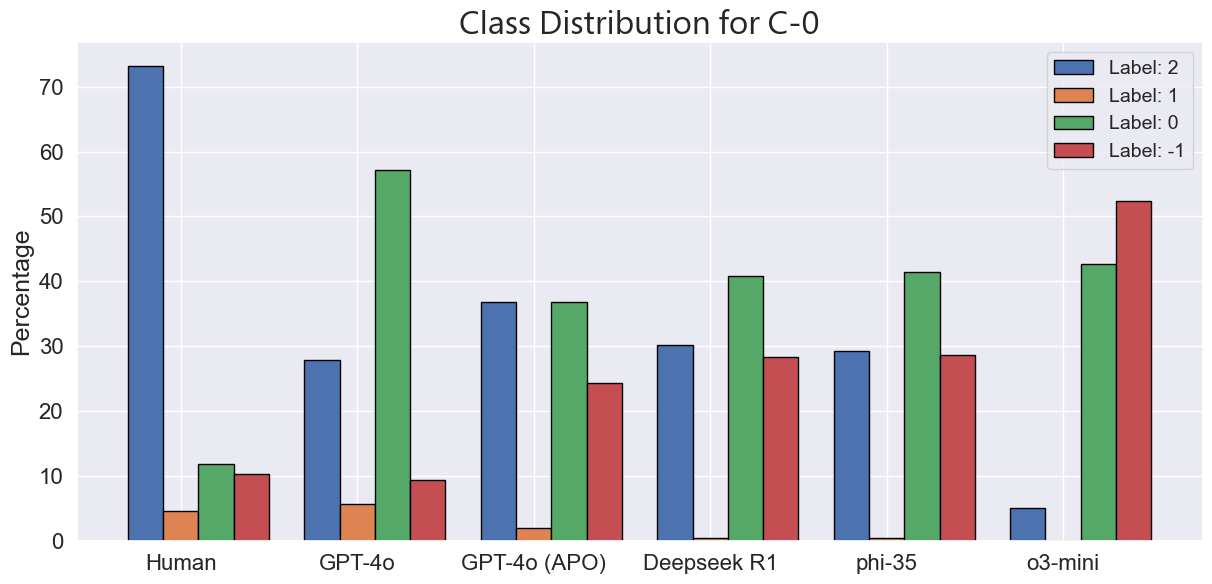

2 [71.14, 79.84, 86.3, 29.94, 38.45, 64.87]
1 [2.64, 0.29, 0.39, 0.0, 0.59, 2.15]
0 [3.82, 5.19, 1.17, 0.98, 1.27, 0.0]
-1 [22.41, 14.68, 12.13, 69.08, 59.59, 32.97]


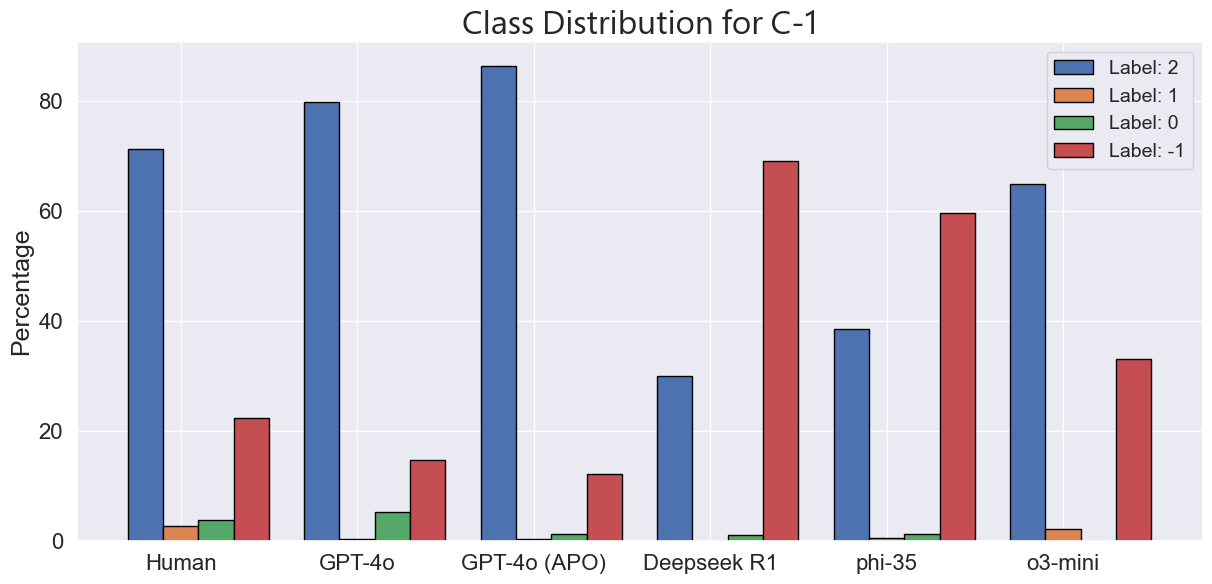

2 [71.04, 70.84, 72.9, 29.35, 38.45, 51.47]
1 [2.45, 1.66, 0.59, 0.1, 0.59, 0.29]
0 [4.11, 20.06, 12.92, 6.75, 1.96, 1.66]
-1 [22.41, 7.44, 13.6, 63.8, 59.0, 46.58]


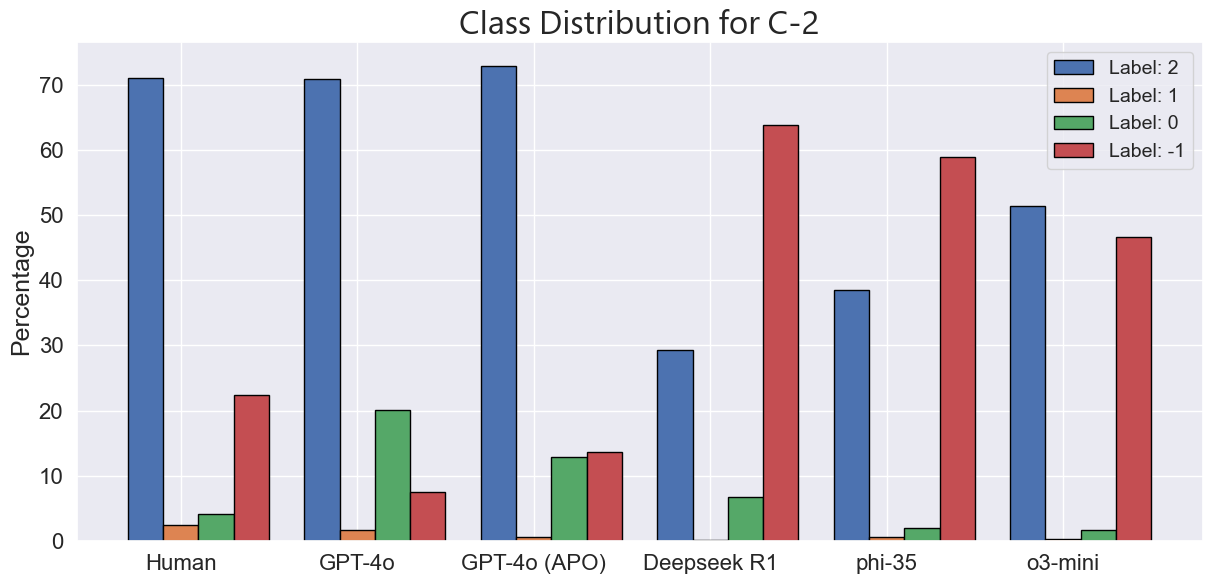

2 [69.96, 21.62, 33.37, 21.14, 7.14, 22.02]
1 [3.13, 29.06, 13.41, 0.88, 3.13, 3.13]
0 [4.7, 35.91, 18.3, 10.86, 7.34, 20.65]
-1 [22.21, 13.31, 34.83, 67.12, 82.39, 50.1]


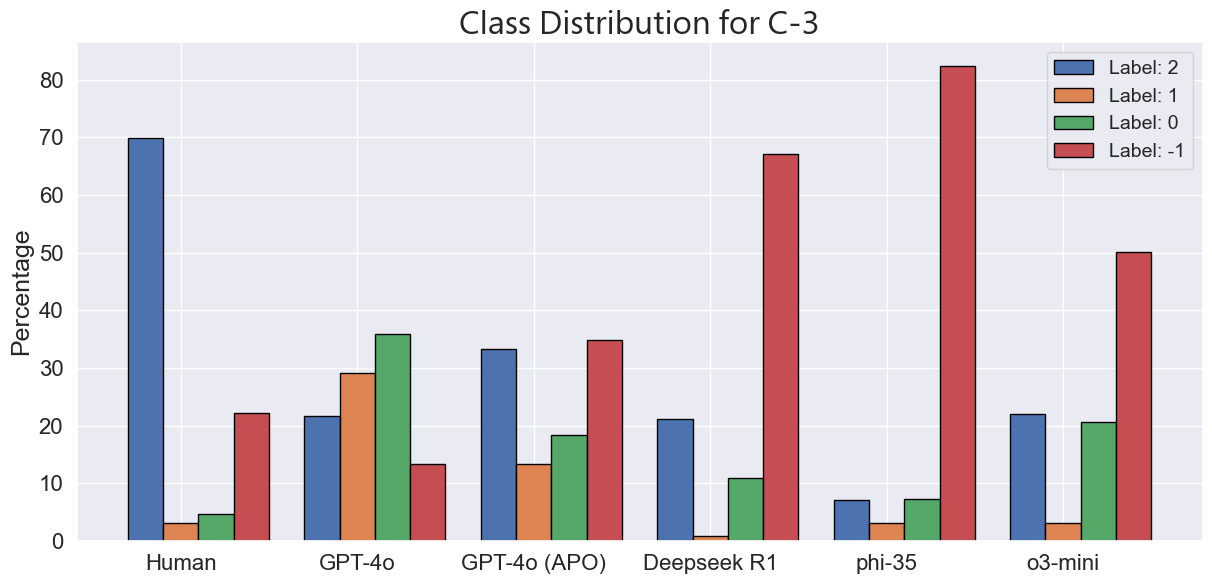

2 [36.4, 16.24, 22.5, 12.43, 16.54, 5.77]
1 [29.16, 49.02, 33.76, 28.67, 19.67, 28.08]
0 [24.07, 21.72, 12.33, 5.68, 16.93, 9.39]
-1 [10.37, 13.01, 31.12, 53.23, 46.87, 51.47]


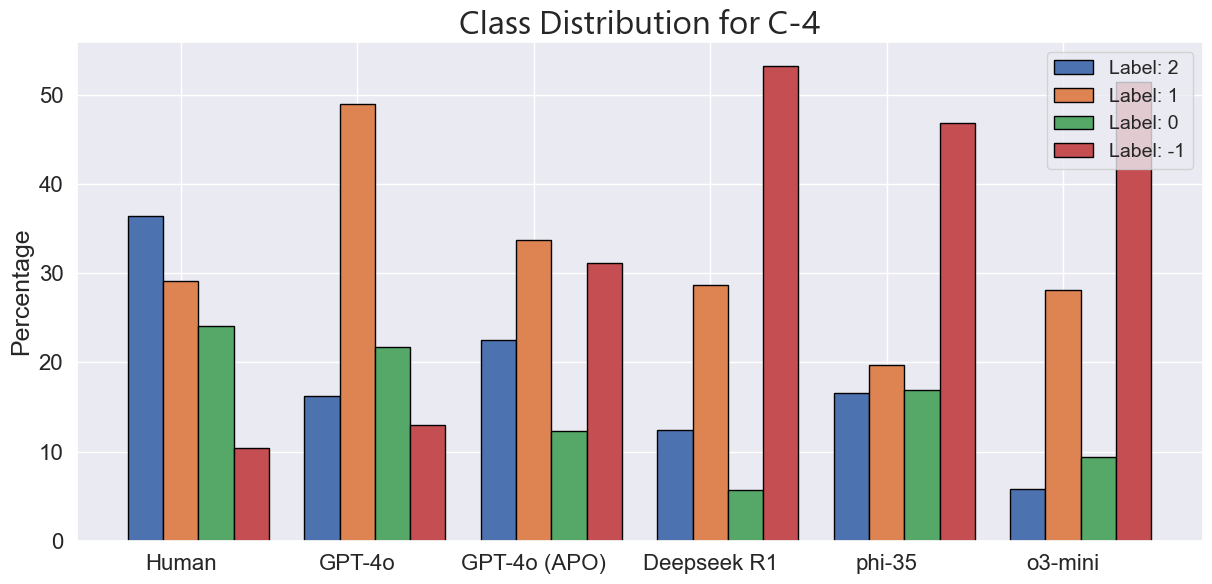

2 [75.34, 90.41, 92.47, 18.0, 36.2, 29.84]
1 [8.02, 4.5, 2.94, 1.47, 11.15, 6.07]
0 [6.26, 1.37, 0.78, 4.11, 16.34, 13.41]
-1 [10.37, 3.72, 3.82, 76.42, 36.3, 41.49]


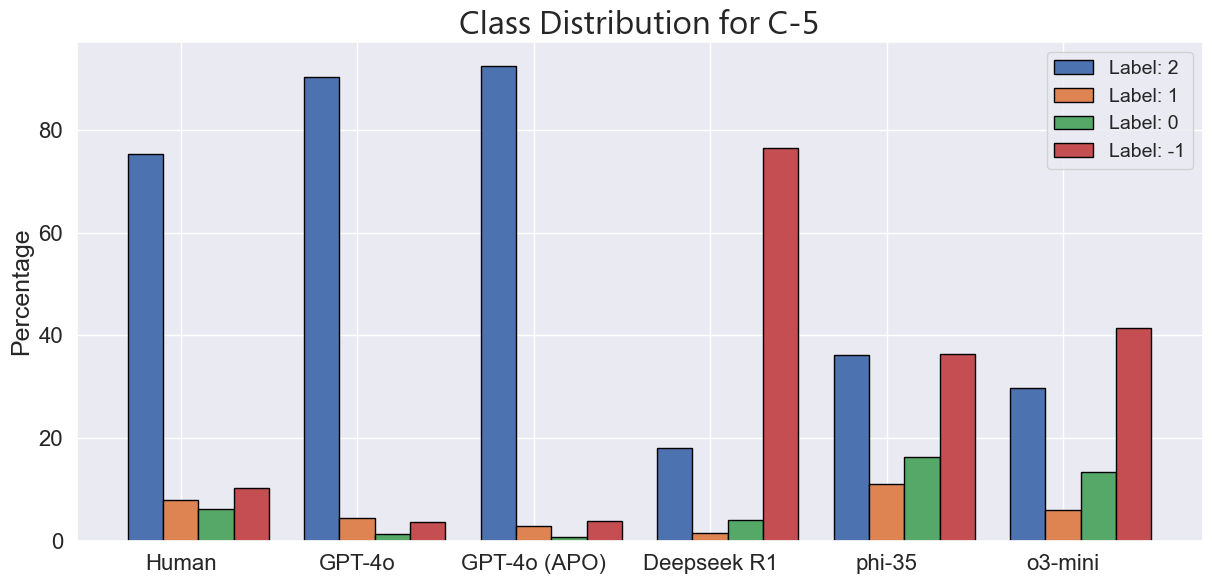

2 [35.81, 12.43, 3.03, 5.38, 7.24, 1.76]
1 [27.98, 37.77, 5.58, 19.77, 20.16, 20.84]
0 [20.84, 29.94, 3.62, 2.84, 17.81, 10.57]
-1 [1.57, 3.62, 1.27, 0.0, 13.89, 1.96]
-2 [3.42, 2.25, 0.1, 0.0, 1.08, 0.1]
-3 [10.37, 13.99, 66.05, 72.02, 39.33, 61.06]


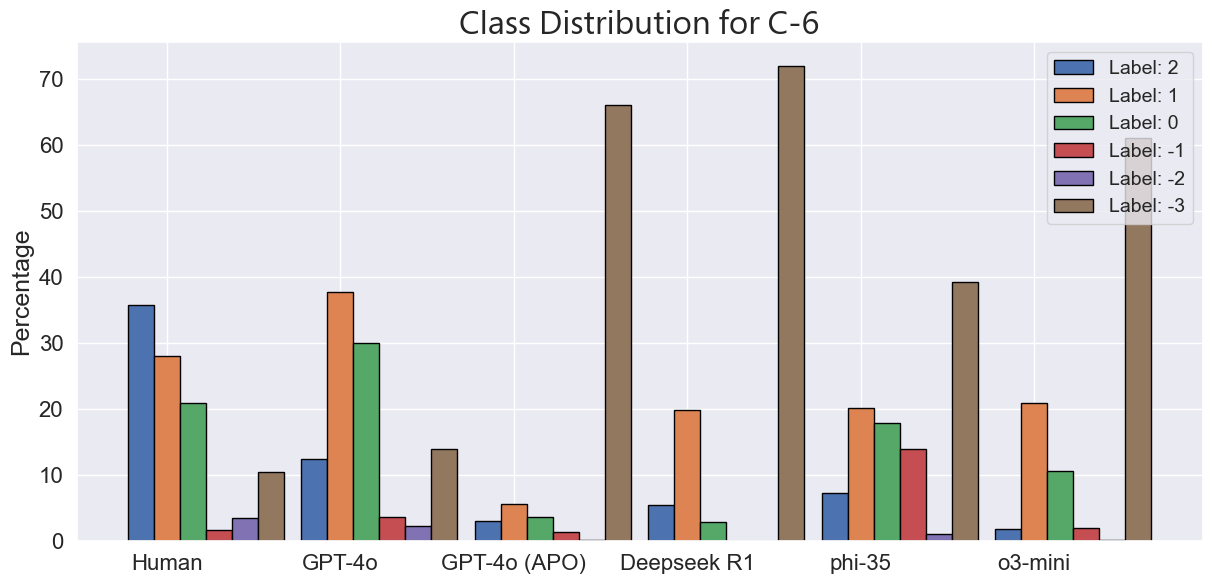

p1 [39.22, 43.14, 33.33, 33.33, 41.18, 33.33]
p2 [37.25, 54.9, 66.67, 66.67, 58.82, 62.75]
draw [23.53, 1.96, 0.0, 0.0, 0.0, 3.92]


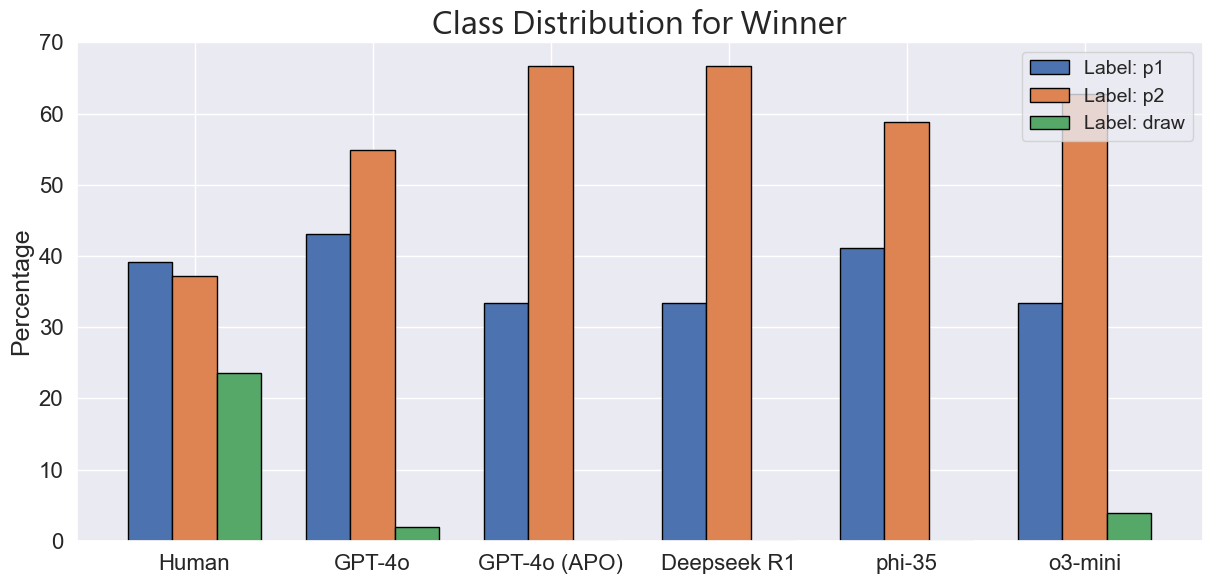

In [32]:
def ccount(flattened, label, criterion):
    if criterion != "Winner":
        return round(flattened.count(label)*100./len(flattened), 2)
    else:
        return round(flattened.count(
            labels_from[criterion].index(label.lower())
            )*100./len(flattened), 2)

for criterion, possible_labels in labels_from.items():

    pre_df = {}
    for model in MODELS:
        if model in []: continue

        # Left is human, right is machine
        all_predictions = classes[model][criterion]
        flattened = [v[0] for v in all_predictions]

        if "Human" not in pre_df:
            pre_df["Human"] = {
                label: ccount(flattened, label, criterion) for label in possible_labels
            }
        flattened = [v[-1] for v in all_predictions]
        pre_df[model] = {
                label: ccount(flattened, label, criterion) for label in possible_labels
        }

    transposed_df = {label: [] for label in possible_labels}
    for model, entries in pre_df.items():
        for label, count in entries.items():
            transposed_df[label].append(count)

    for k, v in transposed_df.items():
        print(k, v)

    # We really don't need a dataframe lol
    ind = np.arange(len(MODELS) + 1) # Account for Human
    bar_width = 0.15
    if len(possible_labels) == 4:
        bar_width = 0.2
    if len(possible_labels) == 3:
        bar_width = 0.25

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ix = -1
    for label in possible_labels:
        _ = ax.bar(ind + ix*bar_width, transposed_df[label], bar_width, 
                   edgecolor="black", label=f"Label: {label}")
        ix += 1

    #ax.set_ylabel("Count %", fontdict={"size": 16, "fontfamily": "sans-serif"})
    ax.set_title(f'Class Distribution for {criterion}', fontsize=24, fontfamily="Segoe Pro")
    ax.set_xticks(ind)
    ax.set_xticklabels([maptocol[v] for v in ["Human"] + MODELS], rotation=0, fontdict={"size": 16}) #, fontdict={"size": 16, "fontfamily": "sans-serif"})  # Assuming models is a list of tick labels
    ax.tick_params(axis='y', labelsize=16)
    ax.grid(True)
    plt.legend(loc='upper right', prop={"size":14}) #, prop={"size": 14, "family": "sans-serif"})
    plt.tight_layout()
    plt.ylabel("Percentage", fontdict={"size": 18})
    plt.savefig(f"label{criterion[-1]}.png", dpi=300, bbox_inches = "tight")
    plt.show()
    plt.close()



### Arithmetic / Preferences

In [448]:
who_won = {k: {"p1": 0, "p2": 0, "draw": 0, "count": 0} for k in ["ChatGPT", "LLM + FDM", "LLM + LLM"]}

for ix in dataset.index:
    tid = dataset.loc[ix]["TranscriptId"]
    key = "LLM + FDM"
    if tid.startswith("D"): key = "ChatGPT"
    if "False" in tid: key = "LLM + LLM"

    win = dataset.loc[ix]["Annotations"]["AggregateHuman"]["Winner"].lower()

    who_won[key][win] += 1
    who_won[key]["count"] += 1
    
print("------- Annotators ----------")
for k, v in who_won.items():
    print("k:")
    sstr = ""
    for _k, _v in v.items():
        prop = round(_v*100/v["count"], 2)
        sstr += f"{_k}: {prop} |"
    print(sstr)

------- Annotators ----------
k:
p1: 50.0 |p2: 20.0 |draw: 30.0 |count: 100.0 |
k:
p1: 28.57 |p2: 53.57 |draw: 17.86 |count: 100.0 |
k:
p1: 53.85 |p2: 15.38 |draw: 30.77 |count: 100.0 |


gpt-4o-2024-05-13 {'p1': 43.14, 'p2': 54.9, 'draw': 1.96} Consistency 62.75
gpt4o_from_apo {'p1': 33.33, 'p2': 66.67, 'draw': 0.0} Consistency 66.67
deepseek-r1-distill-qwen-32b {'p1': 33.33, 'p2': 66.67, 'draw': 0.0} Consistency 35.29
phi-35-moe-instruct {'p1': 41.18, 'p2': 58.82, 'draw': 0.0} Consistency 70.59
o3-mini {'p1': 33.33, 'p2': 62.75, 'draw': 3.92} Consistency 37.25
AggregateHuman {'p1': 39.22, 'p2': 37.25, 'draw': 23.53} Consistency 72.55
Avgs {'p1': 36.86, 'p2': 61.96, 'draw': 1.18} Average consistency: 54.51


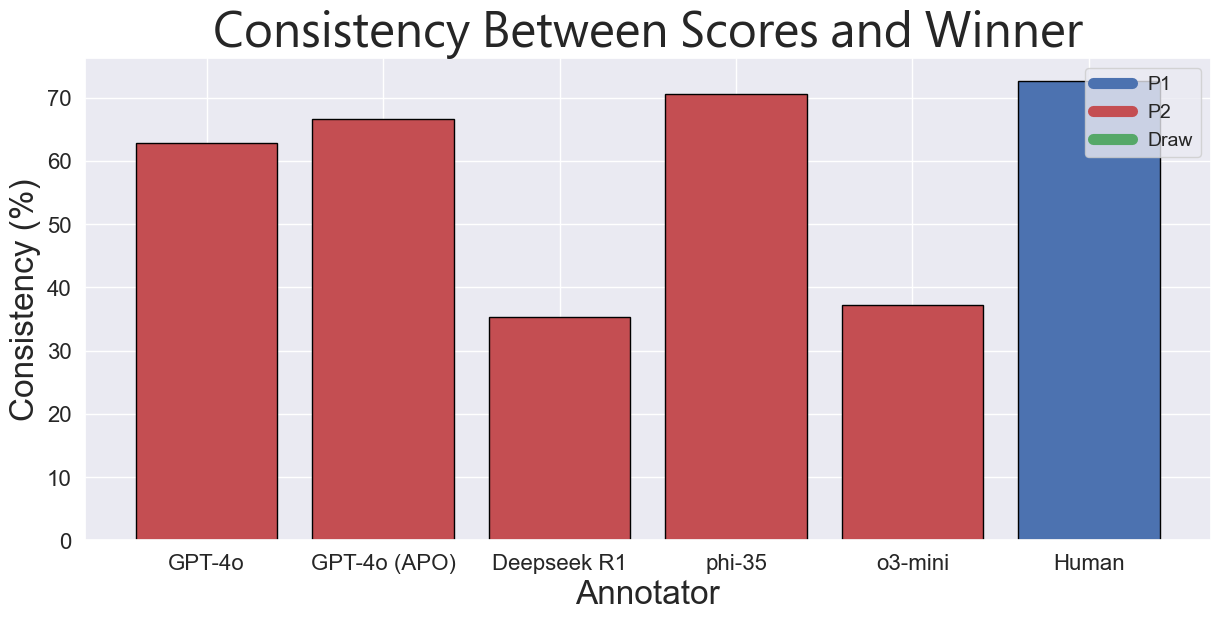

In [41]:
palette_tab10 = sns.color_palette()
palette = sns.color_palette([palette_tab10[0], palette_tab10[3], palette_tab10[2]], as_cmap=True)

def calculate_winners(split):
    # Split: df[model]
    # Return: [winners], {"player":, count}, None?
    winners, most_frequent_winner = [], {"p1": 0, "p2": 0, "draw": 0}
    for ix in df.index:
        win = df.loc[ix]["Annotations"][split]["Winner"].lower()
        if win not in ["p1", "p2", "draw"]:
            win = "draw"
        most_frequent_winner[win] += 1
        # Score: 
        scores = {"p1": 0, "p2": 0}
        for a in df.loc[ix]["Annotations"][split]["TranscriptScores"]:
            if "P1Scores" in a:
                sc = a["P1Scores"]["C-6"]
                if sc is not None: # Same as appending 0
                    scores["p1"] += sc
            if "P2Scores" in a:
                sc = a["P2Scores"]["C-6"]
                if sc is not None:
                    scores["p2"] += sc

        consistent = False
        if scores["p1"] > scores["p2"] and "p1" == win: consistent = True
        if scores["p1"] < scores["p2"] and "p2" == win: consistent = True
        if scores["p1"] == scores["p2"] and "draw" == win: consistent = True
        winners.append(1 if consistent else 0)

    most_frequent_winner_norm = {k: round(v*100/len(winners), 2) for k, v in most_frequent_winner.items()}
    print(split, most_frequent_winner_norm, "Consistency", round(sum(winners)*100./len(winners), 2))
    return winners, most_frequent_winner_norm, None


def get_aggregate_label(split, return_key=False):
    winners, most_frequent_winner, agreed_upon = calculate_winners(split)
    return round(sum(winners)*100./len(winners), 2), most_frequent_winner, max(most_frequent_winner, key=most_frequent_winner.get)

win2col = {
    "p1": palette[0],
    "p2": palette[1],
    "draw": palette[2]
}

SPLITS = MODELS + ["AggregateHuman"]
agg_labels = [get_aggregate_label(h) for h in SPLITS]
all_values = [p[0] for p in agg_labels]
color_codes = [win2col[p[-1]] for p in agg_labels]
avgs = {"p1": 0, "p2": 0, "draw": 0}
for _, d, _ in agg_labels[:-1]: # no human
    for k, v in d.items():
        avgs[k] += v
avgs = {k: round(v/len(SPLITS[:-1]), 2) for k, v in avgs.items()}
print("Avgs", avgs, "Average consistency:", round(sum(all_values[:-1])/len(all_values[:-1]), 2))

ind = np.arange(len(SPLITS))
bar_width = 0.80

# Create the bar plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(ind, all_values, bar_width, edgecolor="black", color=color_codes)

ax.set_title(f'Consistency Between Scores and Winner', fontsize=36, fontfamily="Segoe Pro")
ax.set_xticks(ind)
ax.set_xticklabels([maptocol[v] for v in MODELS + ["Human"]], rotation=0, fontdict={"size": 16}) #, fontdict={"size": 16, "fontfamily": "sans-serif"})  # Assuming models is a list of tick labels
#ax.set_ylabel("Score", fontdict={"size": 16, "fontfamily": "sans-serif"})
ax.tick_params(axis='y', labelsize=16)
ax.grid(True)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=c, lw=8) for c in win2col.values()]
ax.legend(custom_lines, ["P1", "P2", "Draw"], fontsize=14)

#plt.legend(loc='upper right', prop={"size":14}) #, prop={"size": 14, "family": "sans-serif"})
plt.tight_layout()
plt.xlabel("Annotator", fontdict={"size": 24})
plt.ylabel("Consistency (%)", fontdict={"size": 24})
plt.savefig(f"consistency.png", dpi=300, bbox_inches = "tight")
plt.show()
plt.close()



### Audio

In [605]:
import json
import pandas as pd
import numpy as np

group1 = pd.read_json("audio_annotations/group1_audio_annotations.json")
group2 = pd.read_json("audio_annotations/group2_audio_annotations.json")
group3 = pd.read_json("audio_annotations/group3_audio_annotations.json")

def get_majority_vote(scores):
    """
    Get majority vote for an array
    """
    _z = Counter(scores)
    z = _z.most_common()
    if len(z) > 1:
        if z[0][-1] == z[1][-1]:
            return int((z[0][0] + z[1][0])/2)
    return z[0][0]


# self-reported tids where participants reported changing their mind
transcripts_changed = [
"56954154259491798",
"1723213998376259369",
"1693441422520476941",
"257105952455861909",
"D-9"
]

In [464]:
def avg(arr):
    return round(np.array(arr).mean()*100, 1)

def get_changed_positions(per_df=None):

    c_pos_group1, c_pos_group2, c_pos_group3 = [], [], []

    if per_df is None:
        t_ids_with_changes = {}
        for i in group1.index:
            tid = group1.iloc[i]["FileName"].replace(".mp3", "").strip()
            for j in range(1, 6):
                row1 = group1.iloc[i]["Annotations"][f"A{j}"]["Did your position change?"]
                row2 = group2.iloc[i]["Annotations"][f"A{j}"]["Did your position change?"]
                row3 = group3.iloc[i]["Annotations"][f"A{j}"]["Did your position change?"]
                if "unchanged" not in row1.lower():
                    c_pos_group1.append(1)
                    if tid not in t_ids_with_changes: t_ids_with_changes[tid] = 0
                    t_ids_with_changes[tid] += 1
                else: c_pos_group1.append(0)
                if "unchanged" not in row2.lower():
                    c_pos_group2.append(1)
                    if tid not in t_ids_with_changes: t_ids_with_changes[tid] = 0
                    t_ids_with_changes[tid] += 1
                else: c_pos_group2.append(0)
                if "unchanged" not in row3.lower():
                    c_pos_group3.append(1)
                    if tid not in t_ids_with_changes: t_ids_with_changes[tid] = 0
                    t_ids_with_changes[tid] += 1
                else: c_pos_group3.append(0)
        return c_pos_group1, c_pos_group2, c_pos_group3, t_ids_with_changes
    else:
        for i in per_df.index:
            for j in range(1, 6):
                row1 = per_df.loc[i]["Annotations"][f"A{j}"]["Did your position change?"]
                if "unchanged" not in row1.lower():
                    c_pos_group1.append(1)
                else: c_pos_group1.append(0)
        return c_pos_group1


c_pos_group1, c_pos_group2, c_pos_group3, t_ids_with_changes = get_changed_positions()

counts = 0
ccounts = 0
print("Positions that changed:")
print("Group 1 | Group 2 | Group 3")
print(f"{avg(c_pos_group1)} | {avg(c_pos_group2)} | {avg(c_pos_group3)}")
for k, v in t_ids_with_changes.items():
    print(k, v, k in transcripts_changed)
    counts += v
    ccounts += 1

print(counts/ccounts)

Positions that changed:
Group 1 | Group 2 | Group 3
62.0 | 34.1 | 34.9
D-12 6 False
D-19 7 False
D-20 4 False
D-41 7 False
D-56 10 False
D-771 5 False
D-79 5 False
D-802 4 False
D-88 10 False
D-9 8 True
1120945509144372347 6 False
1157541654167872059 8 False
1169903463394363939 4 False
1430092444751070058 9 False
1474370877509255616 8 False
1634593910942667856 8 False
1635457027571170832 9 False
1643462571721655277 2 False
1693441422520476941 10 True
1723213998376259369 7 True
191031900688179952 3 False
1359369657825364005 8 False
1960294543846792294 8 False
2057213745056445361 5 False
2084272176471105140 10 False
215444357356888076 5 False
2237561139806150536 5 False
22790128963595988 11 False
245239473212996872 5 False
257105952455861909 6 True
287359564641543665 9 False
56954154259491798 10 True
62516033831383499 8 False
645437516456923296 6 False
67711226272113824 5 False
690702760905002014 6 False
808944241360821601 7 False
97770224906136234 3 False
1707407968988207436PFalse 8 Fal

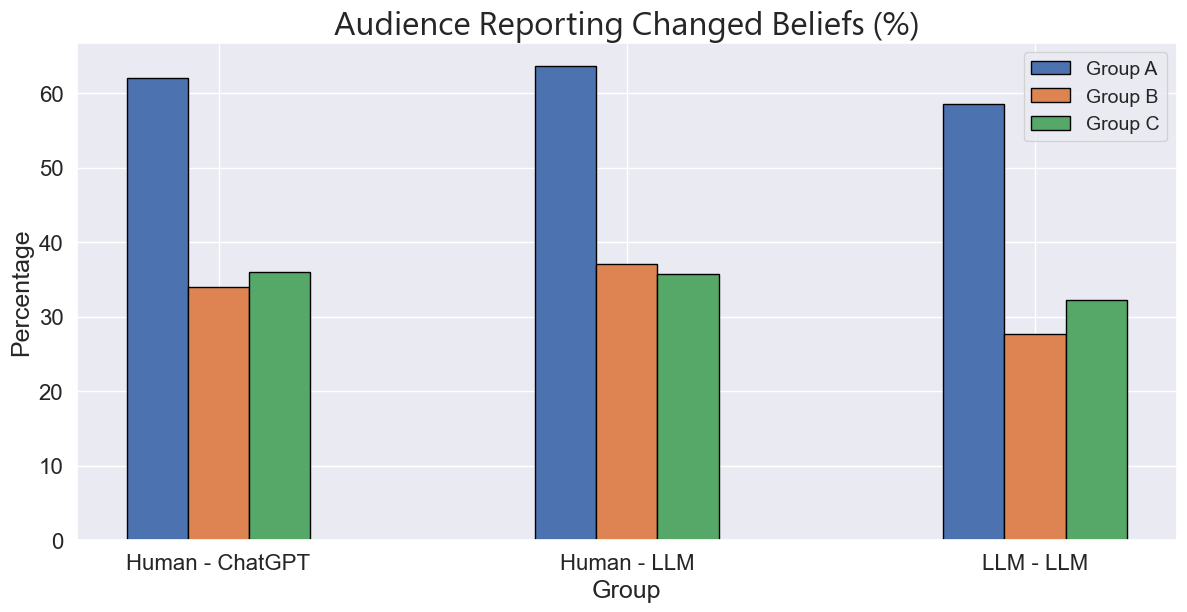

In [465]:
def get_avg_label(group, split):
    _df = group3
    if group == "A":
        _df = group1
    if group == "B":
        _df = group2

    if split == "Chat":
        ixes = [i for i in _df.index if "D-" in _df.loc[i]["FileName"]]
    elif split == "LLM":
        ixes = [i for i in _df.index if "False" in _df.loc[i]["FileName"]]
    else:
        jxes = [i for i in _df.index if "D-" in _df.loc[i]["FileName"]]
        jxes += [i for i in _df.index if "False" in _df.loc[i]["FileName"]]
        ixes = [i for i in _df.index if i not in jxes]

    entries = get_changed_positions(_df.loc[ixes])
    return avg(entries)

SPLITS = ["Human - ChatGPT", "Human - LLM", "LLM - LLM"]
transposed_df = {g: [
                    get_avg_label(g, h) for h in ["Chat", "Human", "LLM"]
                ] for g in ["A", "B", "C"]}

ind = np.arange(len(SPLITS))
bar_width = 0.15

# Create the bar plot
fig, ax = plt.subplots(figsize=(12, 6))
ix = -1
for label in ["A", "B", "C"]:
    _ = ax.bar(ind + ix*bar_width, transposed_df[label], bar_width, 
                edgecolor="black", label=f"Group {label}")
    ix += 1

ax.set_title(f'Audience Reporting Changed Beliefs (%)', fontsize=24, fontfamily="Segoe Pro")
ax.set_xticks(ind)
ax.set_xticklabels(SPLITS, rotation=0, fontdict={"size": 16}) #, fontdict={"size": 16, "fontfamily": "sans-serif"})  # Assuming models is a list of tick labels
ax.set_ylabel("Count %", fontdict={"size": 16, "fontfamily": "sans-serif"})
ax.tick_params(axis='y', labelsize=16)
ax.grid(True)
plt.legend(loc='upper right', prop={"size":14}) #, prop={"size": 14, "family": "sans-serif"})
plt.tight_layout()
plt.xlabel("Group", fontdict={"size": 18})
plt.ylabel("Percentage", fontdict={"size": 18})
plt.savefig(f"audience_changed_beliefs.png", dpi=300, bbox_inches = "tight")
plt.show()
plt.close()



In [634]:
def collect(group, idx):
    collected_responses = {"TID": []}
    for ix in group.index:
        tmp_coll = {"Winner": [], "Agreement": [], "Change": []}
        if idx == 2:
            tmp_coll["AIBelief"] = []
        if idx == 3 or idx == 2:
            tmp_coll["AISway"] = []
        for ax in range(1, 6):
            annos = group.loc[ix]["Annotations"][f"A{ax}"]            
            tmp_coll["Winner"].append(annos["Who won the debate?"])
            tmp_coll["Agreement"].append(annos["Agreement with topic"])
            tmp_coll["Change"].append(annos["Did your position change?"])
            if idx == 2: 
                tmp_coll["AIBelief"].append(annos["Who do you think the AI was?"])
            if idx == 3 or idx == 2:
                tmp_coll["AISway"].append(annos["How was your choice of winner influenced by your belief about who the AI is?"])
        for k, v in tmp_coll.items():
            _v = [int(a[0]) for a in v]
            maj_vote = get_majority_vote(_v)
            if k not in collected_responses: collected_responses[k] = []
            collected_responses[k].append(maj_vote)
        collected_responses["TID"].append(group.loc[ix]["FileName"])
    return collected_responses

ix2gp = {0: "A", 1: "B", 2: "C"}


def flip(a):
    if a == 3:
        return -1
    if a == 2:
        return -2
    if a == 1:
        return -3


Kappa: 0.3162425491665775


C:\Users\adewynter\AppData\Local\Temp\ipykernel_20268\2707000176.py:42: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



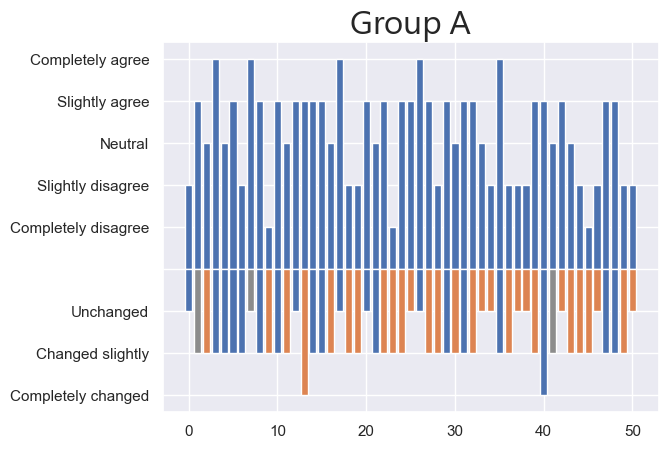

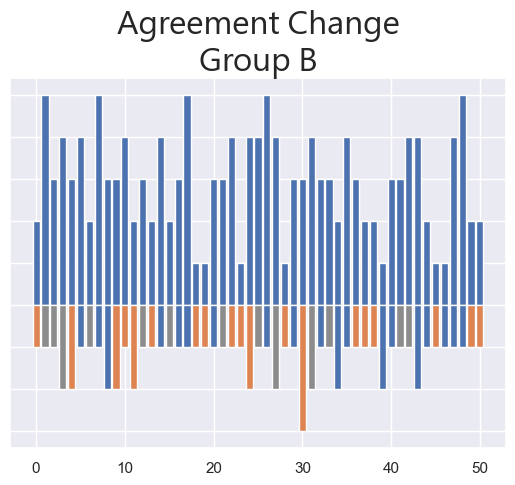

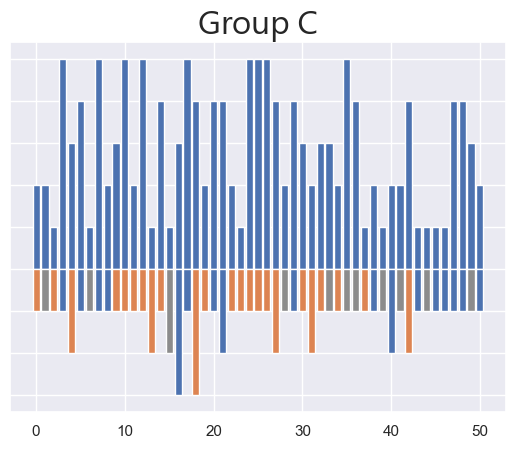

In [640]:
agreement_change_tick_map = {
    -5: "", 5: "Completely agree", 6: "", 0: "",
    -4: "", 4: "Slightly agree",
    -1: "Unchanged", 3: "Neutral",
    -2: "Changed slightly", 2: "Slightly disagree",
    -3: "Completely changed", 1: "Completely disagree"
}
winner_shade_map = {
    3: "#dd8452", #p2
    2: "#8c8c8c", #draw
    1: '#4c72b0',
    #4: "?"
}

kappas = []
groups = [group1, group2, group3]
for i in range(len(groups) - 1):
    responses = collect(groups[i], i + 1)
    win1 = responses["Winner"]
    for j in range(i, len(groups)):
        responses = collect(groups[j], j + 1)
        win2 = responses["Winner"]
        if i == j: continue
        kappas.append(
            cohen_kappa_score(win1, win2, labels = [1,2,3])
        )
print(f"Kappa: {np.array(kappas).mean()}")

for i, g in enumerate([group1, group2, group3]):
    responses = collect(g, i + 1)
    y = range(len(responses["Change"]))
    d1 = responses["Agreement"]
    d2 = [flip(a) for a in responses["Change"]]
    cold1 = [winner_shade_map[p] for p in responses["Winner"]]

    fig, ax = plt.subplots()
    ax.bar(y, d1, label="Before")
    ax.bar(y, d2, color=cold1, label="After")
    ticks =  ax.get_yticks()
    ax.set_ylim((-3.4, 5.4))
    if i == 0:
        ax.set_yticklabels([agreement_change_tick_map[int(tick)] for tick in ticks])
    else:
        ax.set_yticklabels([])

    plt.title(f"Agreement Change\nGroup {ix2gp[i]}" if i == 1 else f"Group {ix2gp[i]}", fontsize=24, fontfamily="Segoe Pro")
    plt.savefig(f"beliefs_group_{i+1}.png", dpi=300, bbox_inches = "tight")
    #plt.legend()
    plt.show()

Accuracy: 0.5294117647058824


C:\Users\adewynter\AppData\Local\Temp\ipykernel_20268\138238097.py:39: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



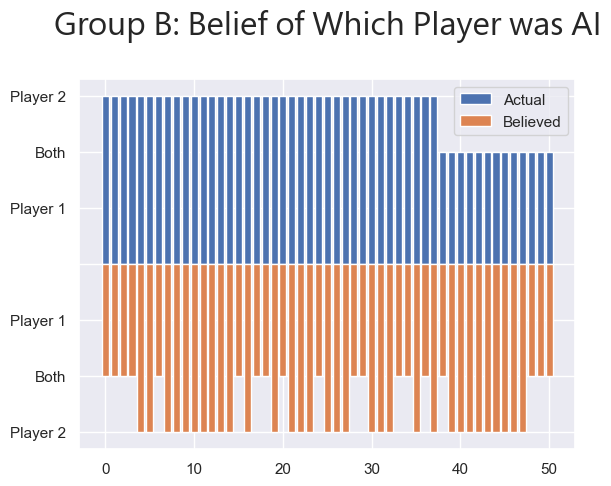

In [639]:
def retrieve_and_map(t_id):
    t_id = t_id.replace(".mp3", "")
    row = dataset[dataset.TranscriptId == t_id]["Metadata"]
    ix = row.first_valid_index() # My god pandas is so hard to use
    row = row[ix]
    if row["P1"].lower() == row["P2"].lower():
        return 2 # Both
    elif row["P1"].lower == "human":
        return 1
    else:
        return 3 # P2

agreement_change_tick_map = {
    -5: "", 5: "Completely agree", 6: "", 0: "",
    -4: "", 4: "Slightly agree",
    -3: "Player 2", 3: "Player 2",
    -2: "Both", 2: "Both",
    -1: "Player 1", 1: "Player 1"
}
winner_shade_map = {
    3: "#dd8452", #p2
    2: "#8c8c8c", #draw
    1: '#4c72b0',
    4: "?"
}

responses = collect(group2, 2)
y = range(len(responses["AIBelief"]))
d1 = [retrieve_and_map(t) for t in responses["TID"]]
d2 = [-1*a for a in responses["AIBelief"]]

print(f"Accuracy: {np.array([a == b for a, b in zip(responses["AIBelief"], d1)]).mean()}")
#cold1 = [winner_shade_map[p] for p in responses["Winner"]]

fig, ax = plt.subplots()
ax.bar(y, d1, label="Actual")
ax.bar(y, d2, label="Believed")
ticks =  ax.get_yticks()
ax.set_yticklabels([agreement_change_tick_map[int(tick)] for tick in ticks])

plt.title(f"Group B: Belief of Which Player was AI\n", fontsize=24, fontfamily="Segoe Pro")
plt.savefig(f"which_ai.png", dpi=300, bbox_inches = "tight")
plt.legend()
plt.show()

Kappa: 0.3692579505300353


C:\Users\adewynter\AppData\Local\Temp\ipykernel_20268\4247539582.py:37: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



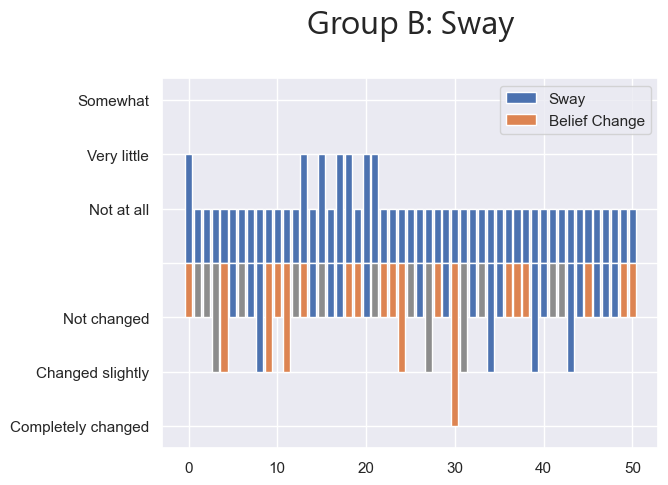

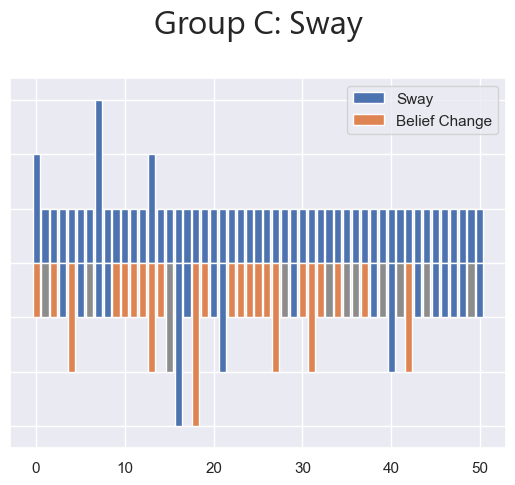

In [642]:
agreement_change_tick_map = {
    -5: "", 5: "Fully", 6: "", 0: "",
    -4: "", 4: "Very much",
    -3: "Completely changed", 3: "Somewhat",
    -2: "Changed slightly", 2: "Very little",
    -1: "Not changed", 1: "Not at all"
}
winner_shade_map = {
    3: "#dd8452", #p2
    2: "#8c8c8c", #draw
    1: '#4c72b0',
    4: "?"
}

responses = collect(group2, 2)
win1 = responses["Winner"]
responses = collect(group3, 3)
win2 = responses["Winner"]
kappa = cohen_kappa_score(win1, win2, labels = [1,2,3])
print(f"Kappa: {kappa}")

for i, g in enumerate([group1, group2, group3]):
    if i == 0: continue
    responses = collect(g, i + 1)
    y = range(len(responses["Change"]))
    d1 = [a for a in responses["AISway"]]
    d2 = [flip(a) for a in responses["Change"]]
    cold1 = [winner_shade_map[p] for p in responses["Winner"]]

    fig, ax = plt.subplots()
    ax.bar(y, d1, label="Sway")
    ax.bar(y, d2, color=cold1, label="Belief Change")
    ticks =  ax.get_yticks()
    #print(ax.get_ylim())
    ax.set_ylim((-3.4, 3.4))
    if i == 1:
        ax.set_yticklabels([agreement_change_tick_map[int(tick)] for tick in ticks])
    else:
        ax.set_yticklabels([])

    plt.title(f"Group {ix2gp[i]}: Sway\n", fontsize=24, fontfamily="Segoe Pro")
    plt.savefig(f"sway_group_{i+1}.png", dpi=300, bbox_inches = "tight")
    plt.legend()
    plt.show()

### Qual Analysis

In [473]:

for ix in group1.index:
    if ix == 0: continue
    for gi, df in enumerate([group1, group2, group3]):
        if gi == 2:
            print("Topic: ", df.loc[ix]["Topic"])
        else: # To check only one group at a time
            continue
        print(f"------------ group {gi + 1} ------------")
        for ax in range(1, 6):
            annos = df.loc[ix]["Annotations"][f"A{ax}"]
            expl = annos["Who won the debate? (explanation)"]
            win = annos["Who won the debate?"]
            agr = annos["Agreement with topic"]
            #ai = None # annos["Who do you think the AI was?"]
            ai = annos["How was your choice of winner influenced by your belief about who the AI is?"]
            chang = "unchanged" not in annos["Did your position change?"].lower()
            print(ax, win, chang, agr, ai, "\n", expl)
    print("\n\n")


Topic:  Taxation is theft
------------ group 3 ------------
1 3: Player 2 False 2: Slightly disagree 1: Not at all 
 Player 2 made a lot of good arguments as to why taxation differs from theft. It makes clear that it is authorized by the governing body for the collective benefit of society.  For every argument Player 1 had, Player 2 had a good explanation as to why it isn't theft.
2 1: Player 1 True 2: Slightly disagree 2: Very little 
 Player 1 won the debate because the AI kept defaulting to the same argument that taxation is not theft because the government gives it legitimacy but never adequately addresses Player 1's argument that they can't make taxation fit the definition of theft just by saying that it is OK.
3 3: Player 2 False 1: Completely disagree 1: Not at all 
 Taxation is distinct from theft because it is authorized by the government for the purpose of funding public services and infrastructure, whereas theft involves unlawfully taking property or funds from individuals w